In [28]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split

# import data and add default data to main dataframe
df = pd.read_csv('/Users/chrisjackson/XXXX/1_Financial Data.csv')
df2 = pd.read_csv('/Users/chrisjackson/XXXX/2_Default Data.csv')
df['default'] = np.where(df['LOAN_ID'].isin(df2['LOAN_ID']), 1, 0)
df['PD_RISK_RATING'] = df['PD_RISK_RATING'].astype('object')
# set X and y
# X = df.drop(['PD_RISK_RATING', 'default', 'LOAN_ID'], axis=1)
X = df[['X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'X9', 'X11', 'PD_RISK_RATING']]
y = df['default']

# set up pipeline for imputation and scaling of categorical variables and numerical variables
num_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
cat_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# get column indexes for categorical and numerical variables
num_features = df.select_dtypes(include=['int64', 'float64']).drop(['default'], axis=1)
cat_features = df.select_dtypes(include=['object']).drop(['LOAN_ID'], axis=1)

numeric_cols = df.dtypes.apply(lambda x: x.kind in 'bifc').reset_index(
    drop=True).loc[lambda x: x == True].index
cat_cols = (df.dtypes == 'object').reset_index(
    drop=True).loc[lambda x: x == True].index

# set up column transformer for categorical and numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transform,  selector(dtype_exclude="object")),
        ('cat', cat_transform, selector(dtype_include="object"))])


In [ ]:
num_features

In [29]:
# use pipeline to impute and scale numerical variables and one hot encode categorical variables
X_pipe = preprocessor.fit_transform(X)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_pipe, y, test_size=0.30, random_state=42, stratify=y)

In [30]:
# used this from a stack overflow post to get feature names from column transformer link: https://johaupt.github.io/blog/columnTransformer_feature_names.html

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [11]:
from imblearn.combine import SMOTEENN

os = SMOTEENN(random_state=42)

os_data_X, os_data_y = os.fit_resample(X_train, y_train)

## Modelling


In [31]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.93      0.69      0.79        39

    accuracy                           1.00      3000
   macro avg       0.96      0.85      0.90      3000
weighted avg       1.00      1.00      0.99      3000



/var/folders/5q/1h7fcv954qj2xln19k_k5zfw0000gn/T/ipykernel_62267/1809191144.py:30: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/var/folders/5q/1h7fcv954qj2xln19k_k5zfw0000gn/T/ipykernel_62267/1809191144.py:30: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


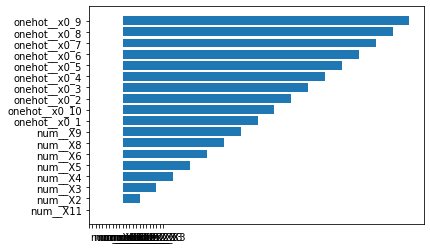

[[ 0.11484273 -0.81005005 -1.8391077  -2.55142618 -0.08205876  0.07131579
  -0.04371965 -0.05332724  0.59468473  0.39032734 -0.50139663 -0.7097829
  -0.54662291 -0.47932829 -0.24227469 -0.50560665  1.          1.        ]]


In [32]:
clf = SVC(C=1, class_weight={0: 1}, gamma=1, kernel='linear', probability=True,
      random_state=42)
clf.fit(X_train, y_train)
predic = clf.predict(X_test)
print(classification_report(y_test, predic))


feature_names = get_feature_names(preprocessor)
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.xticks(np.arange(-2, 2.5, step=0.2))
    plt.show()


df = pd.DataFrame(clf.coef_, columns = feature_names)
f_importances(df, feature_names)
print(clf.coef_)

In [33]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1.0,
                enable_categorical=False, eval_metric='logloss', gamma=1,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=4,
                min_child_weight=5, monotone_constraints='()',
                n_estimators=100, n_jobs=10, num_parallel_tree=1,
                predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
                scale_pos_weight=1, subsample=0.8, tree_method='exact',
                use_label_encoder=False, validate_parameters=1, verbosity=None)
xgb.fit(X_train, y_train)
predic = xgb.predict(X_test)
print(classification_report(y_test, predic))

df = df.append(pd.Series(xgb.feature_importances_), ignore_index=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.90      0.72      0.80        39

    accuracy                           1.00      3000
   macro avg       0.95      0.86      0.90      3000
weighted avg       1.00      1.00      1.00      3000



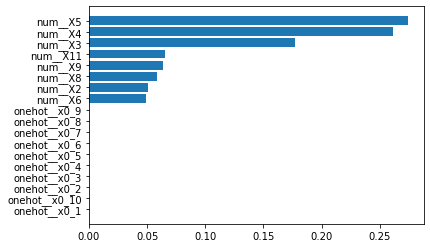

In [34]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()


f_importances(xgb.feature_importances_, feature_names)

In [27]:
print(xgb.feature_importances_)

[0.05045393 0.17720903 0.2609852  0.27401853 0.04941988 0.05884484
 0.06384706 0.06522153 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
